## Imports

In [1]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
from scipy import io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
%matplotlib inline

import os

from keras.constraints import NonNeg, UnitNorm
from tensorflow.keras.layers import Dense, Dropout, Activation, Add
from tensorflow.keras import Model, Sequential, layers, optimizers, activations, Input
from sklearn.feature_extraction.image import extract_patches_2d


In [2]:
from Utils import SAD, numpy_SAD, loss, train, order_endmembers, plotEndmembers, plotEndmembersAndGT, plotAbundancesSimple, load_HSI


## Use GPU

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()


Num GPUs Available:  1


True

# Method training_input_fn

Extracts patches for training 

In [5]:
def training_input_fn(hsi, patch_size, patch_number, batch_size):
    patches = extract_patches_2d(hsi, (patch_size, patch_size), max_patches=patch_number)
    return patches

# Class SumToOne

Enforces the ASC. Regularizations on the abundance maps go in here. 

In [6]:
class SumToOne(tf.keras.layers.Layer):
    def __init__(self, params, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        self.num_outputs = params['num_endmembers']
        self.params = params
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        
    def call(self, x):
        x = tf.nn.softmax(self.params['scale'] * x)
        return x

# Class Encoder

Extends the Model class. Encodes input patches

In [27]:
class Encoder(tf.keras.Model):

    def __init__(self, params):
        super(Encoder, self).__init__()
        self.params = params   
        self.hidden_layer_one = tf.keras.layers.Conv2D(filters=32,
                                                       kernel_size=(self.params['e_size']),
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=params['initializer'], use_bias=False)
            
        self.hidden_layer_two = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3),
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=self.params['initializer'], use_bias=False)
        
        self.hidden_layer_three = tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3),
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=self.params['initializer'], use_bias=False)
                
            
        self.hidden_layer_four = tf.keras.layers.Conv2D(filters=4, kernel_size=(1,1),
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=self.params['initializer'], use_bias=False)
        
        
        # ------------------------------------------------------------------------------------------------------------
        
        self.hidden_layer_skip = tf.keras.layers.Conv2D(filters=16, kernel_size=(1,1),
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=self.params['initializer'], use_bias=False)
        # ------------------------------------------------------------------------------------------------------------

       
        self.asc_layer = SumToOne(params=self.params, name='abundances')

    def call(self, input_patch):
        
        # Hold information --> Skip 
        
        skip = input_patch
        skip = self.hidden_layer_skip(skip)
        skip = tf.keras.layers.BatchNormalization()(skip)
        skip = tf.keras.layers.SpatialDropout2D(0.2)(skip)
     
        code = self.hidden_layer_one(input_patch)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
                
        code = self.hidden_layer_two(code)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        
        
        code = tf.keras.layers.Add()([skip, code]) # Skip connection 1
                            
        code = self.hidden_layer_three(code)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        
        code = self.hidden_layer_four(code)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)        

        code = self.asc_layer(code)
        
        return code

# Class Decoder

Extends the Layer class. Decodes abundance patches and reconstructs the inputs to the encoder.

In [28]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.output_layer = tf.keras.layers.Conv2D(filters=params['d_filters'], kernel_size=params['d_size'],
                                                   activation='linear',
                                                   kernel_constraint=tf.keras.constraints.non_neg(),
                                                   name='endmembers', strides=1, padding='same',
                                                   kernel_regularizer=None,
                                                   kernel_initializer=params['initializer'], use_bias=False)

    def call(self, code):
        recon = self.output_layer(code)
        return recon

    def getEndmembers(self):
        return self.output_layer.get_weights()
    


# Class Autoencoder

In [43]:
class Autoencoder(tf.keras.Model):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(params)
        self.decoder = Decoder(params)
        self.params = params

    def call(self, patch):
        abunds = self.encoder(patch)
        output = self.decoder(abunds)
        return output

    def getEndmembers(self):
        endmembers = self.decoder.getEndmembers()[0]
        if endmembers.shape[1] > 1:
            endmembers = np.squeeze(endmembers).mean(axis=0).mean(axis=0)
        else:
            endmembers = np.squeeze(endmembers)
        return endmembers

    def getAbundances(self, hsi):
        return np.squeeze(self.encoder.predict(np.expand_dims(hsi, 0)))

    def train(self, patches, callback):
        self.plotWhileTraining = callback
        self.fit(patches, patches, epochs=self.params['epochs'], batch_size=self.params['batch_size'],
                 callbacks=[self.plotWhileTraining], verbose=0)


    def saveResults(self, fname):
        endmembers = self.getEndmembers()
        abundances = self.getAbundances(params['data'])
        sads = self.plotWhileTraining.sads
        sio.savemat(fname, {'M': endmembers, 'A': abundances, 'sads': sads})
        

In [44]:
from plot_while_training import PlotWhileTraining


# Set hyperparameters and load data 

In [47]:
# Hyperparmameter settings
n_bands = 162   # Urban: 162 , Samson: 156
num_endmembers = 4 # Urban: 4, Samson: 3
patch_size = 40 
num_patches = 300
batch_size = 15 #15
learning_rate = 0.003  #0.003
epochs = 100 #200

scale = 3 #scaling for softmax
l2 = 0
l1 = 0e-8
tv = 0e-8

activation = tf.keras.layers.ReLU() # tf.keras.layers.LeakyReLU(0.02)
initializer = tf.keras.initializers.RandomNormal(0.0, 0.3)
regularizer = tf.keras.regularizers.l2(l2) #tf.keras.regularizers.l2(l2)

opt = tf.optimizers.Adam(learning_rate=learning_rate, decay=0.0)

# Load dataset

#Dictonary of aliases for datasets. The first string is the key and second is value (name of matfile without .mat suffix)
#Useful when looping over datasets
#datasetnames = {
  #  "Urban": "Urban4",
#}
#dataset = "Urban"

datasetnames = {
    "Urban4": "Urban4",
}
dataset = "Urban4"
data,GT = load_HSI(
    r"C:\Users\......." + datasetnames[dataset] + ".mat"
)

#e_filters is the number of featuremaps in the first hidden layer
#d_size is the decoder's filter size
#e_size is the size of the hidden layer's filter

params = {'e_filters': 32, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
          'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
          'initializer': initializer, 'l1': l1, 'tv': tv, 'patch_size': patch_size,
          'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs}



# Run experiment

Run number: 1


C:\Users\levih\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


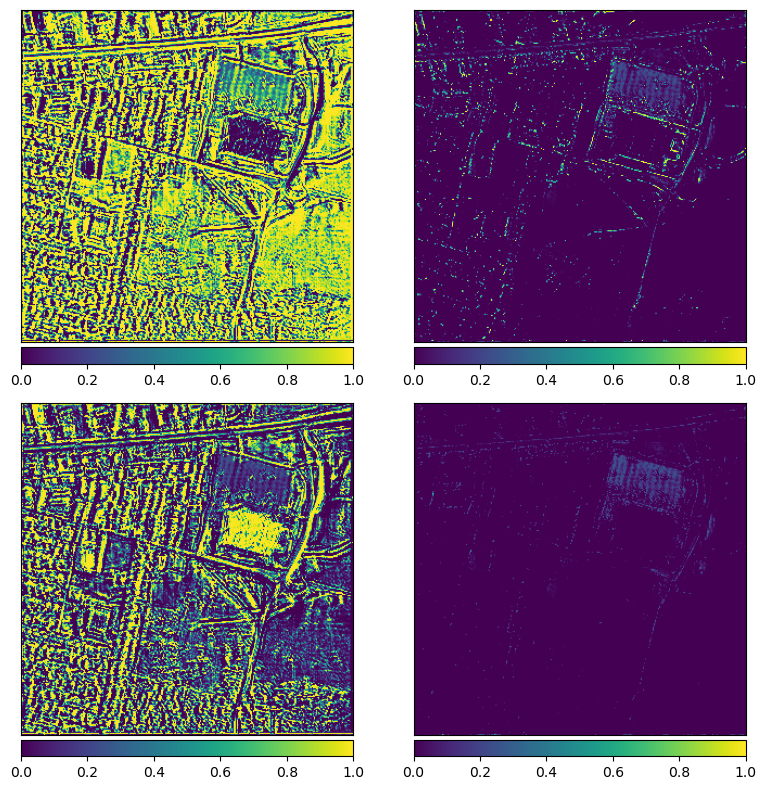

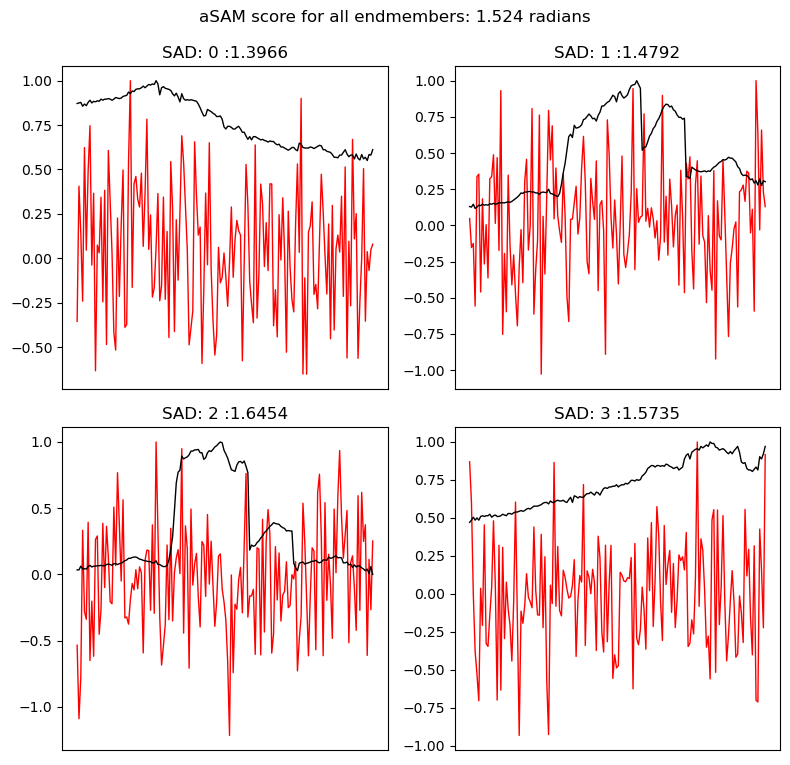

Run number: 2
****************************************************************************************************

C:\Users\levih\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


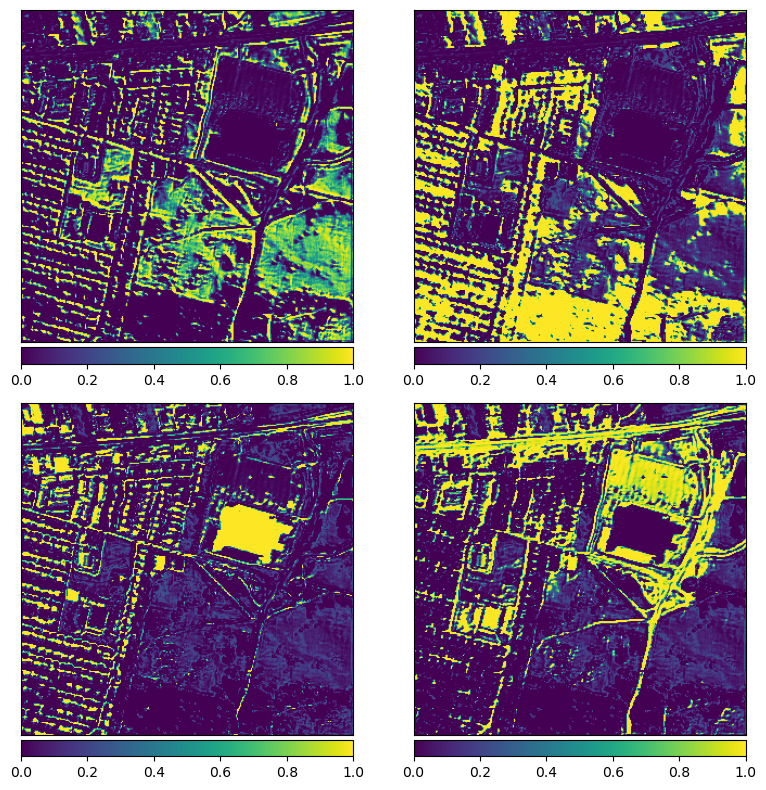

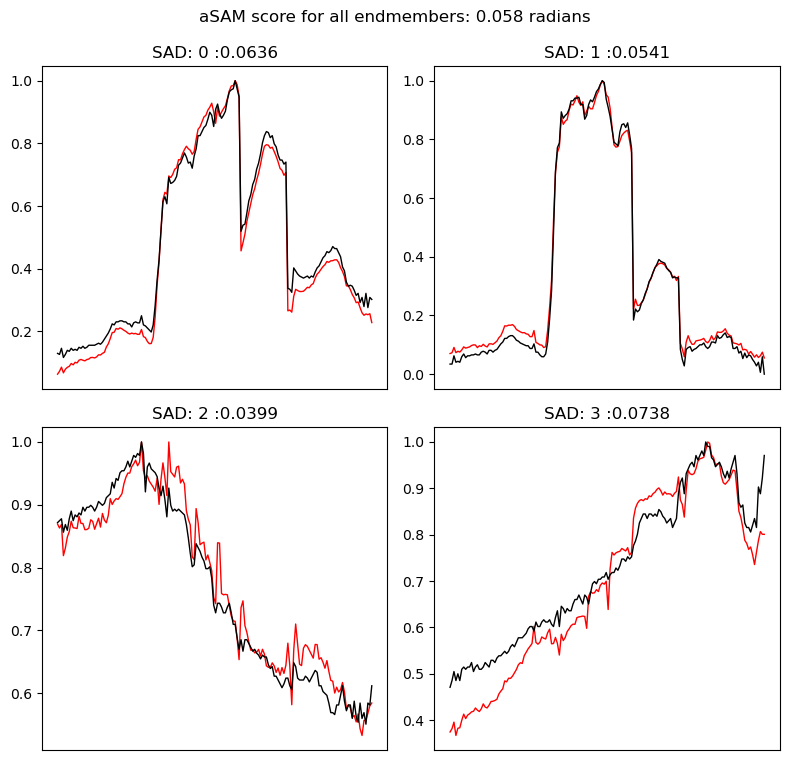

Run number: 3
********************************************************************************************************************************************************************************************************

C:\Users\levih\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


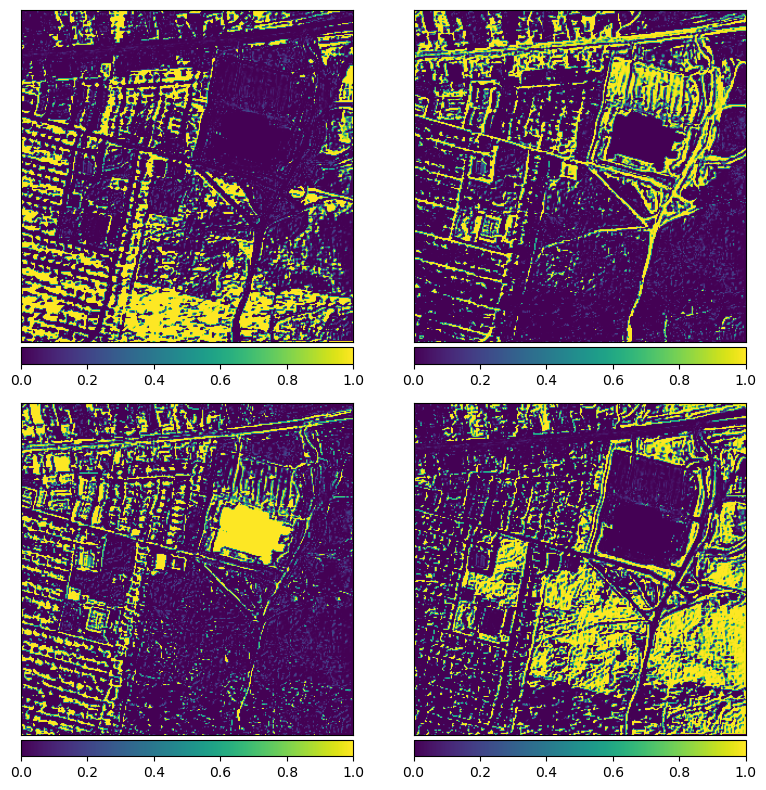

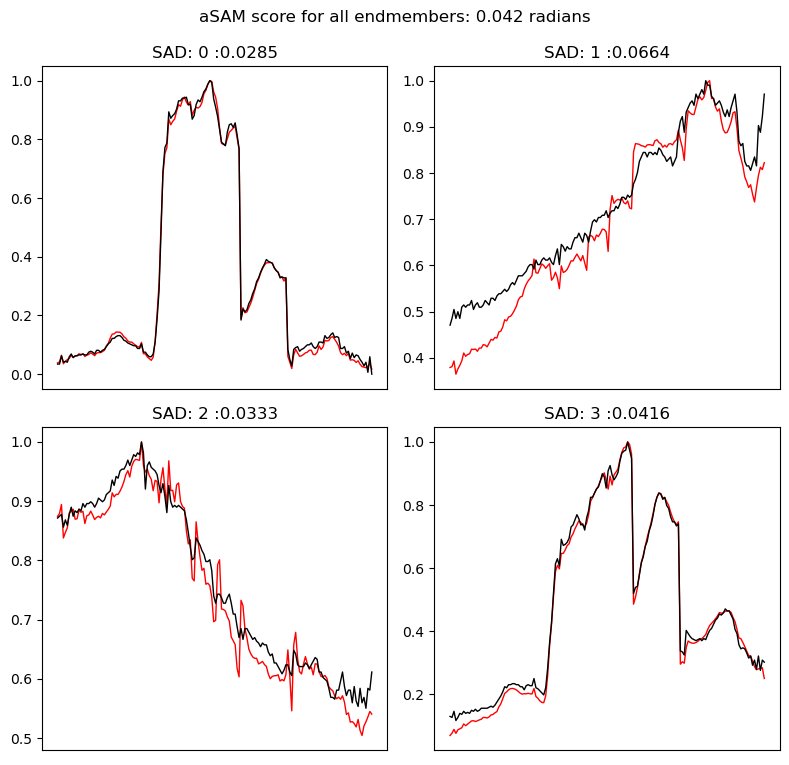

In [48]:
num_runs = 3
results_folder = r'C:\Users\......'
method_name = 'RCAE'

plot_every_n = 0 #Plot endmembers and abundance maps every x epochs. Set to 0 when running experiments. 
for dataset in ['Urban4']:
    save_folder = results_folder+'/'+method_name+'/'+dataset
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    dataset_name = 'synthetic'

    data,GT = load_HSI(
        r"C:\Users\......." + datasetnames[dataset] + ".mat"
    )
    for i in range(num_runs):
        print('Run number: '+str(i+1))
        save_name = dataset_name+'_run'+str(i)+'.mat'
        save_path = save_folder+'/'+save_name
        patches = training_input_fn(data, patch_size, num_patches, batch_size)
        params = {'e_filters': 48, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
              'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
              'initializer': initializer, 'patch_size': patch_size,
              'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs*i}
        autoencoder = Autoencoder(params)

        autoencoder.compile(opt, loss=SAD)
        autoencoder.train(callback=PlotWhileTraining(plot_every_n, data, GT), patches=patches)
        endmembers = autoencoder.getEndmembers()
        abundances = autoencoder.getAbundances(data)
        plotAbundancesSimple(abundances)
        plotEndmembersAndGT(endmembers,GT)
        autoencoder.saveResults(save_path+'_run' + str(i+1) + '.mat')
        #del autoencoder

In [37]:
AbundanceGT = sio.loadmat(r'C:\Users\levih\Downloads\hu_autoencoders-main\hu_autoencoders-main\Datasets\Urban4.mat')['S_GT']
AbundanceGT.shape


(307, 307, 4)

In [38]:
# Original Resutls

Extracted = sio.loadmat(r'C:\Users\levih\Downloads\hu_autoencoders-main\ResultModified\CNNAEU\Urban\RCAE\Urban4\synthetic_run0.mat_run1.mat')
EndMember = Extracted['M']
Abundance = Extracted['A']


In [39]:
Abundance = np.reshape(Abundance, (4, 307,307)).T # reshaping -> (endmembers x pixels)
AbundanceGT = np.reshape(AbundanceGT, (4, 307,307)).T
AbundanceGT.shape


(307, 307, 4)

In [40]:
from RootMeanSquaredError import compute_rmse, calculate_rmse

rmse_cls, mean_rmse = compute_rmse(AbundanceGT, Abundance)

print("Class-wise RMSE value:")
for i in range(4):
    print("Class", i + 1, ":", rmse_cls[i])
print("Mean RMSE:", mean_rmse)


Class-wise RMSE value:
Class 1 : 0.54382826599092
Class 2 : 0.5337750697650401
Class 3 : 0.5135552845652062
Class 4 : 0.5179484978634452
Mean RMSE: 0.5274169803716064


In [41]:
rmse = calculate_rmse(AbundanceGT, Abundance)
print(rmse)


161.91701297408318
